# An extended evaluation of the results with various null-modelling appoaches

In [3]:
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc_file_defaults()
from sklearn.preprocessing import StandardScaler
import nilearn
from tqdm import tqdm
from connattractor import network, analysis
%load_ext autoreload
%autoreload 1
%aimport connattractor.network
%aimport connattractor.analysis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### load simulations and embeddings

In [4]:
simresults_all = {}
hopfield_embeddings_all = {}

for noise in [0.33, 0.35, 0.37, 0.39]:
    simresults_all[noise] = analysis.load_simulation('../data_out/default_statespace_' + str(noise) + '.pkl')
    hopfield_embeddings_all[noise] = analysis.load_embedding('../data_out/default_hopfield_embedding_' + str(noise) + '.pkl')

## Fractional occupancy

### load empirical data

In [5]:
import os
# load resting state data
_fd_thr = 0.15
_perc_scrub_thr = 0.5

# load data
from glob import glob
all_ts = []
root_dir = '../data_in/ex_timeseries/'
for f in glob(root_dir + 'bochum-???.tsv'):
    path, filename = os.path.split(f)
    ts = pd.read_csv(f, sep='\t').iloc[:, 1:].values
    ts = StandardScaler().fit_transform(ts)
    fd = pd.read_csv(path + '/FD_' + os.path.splitext(filename)[0] + '.txt', sep=',').values.flatten()
    fd = np.hstack(([0], fd))

    if np.sum(fd>_fd_thr)/len(fd) < _perc_scrub_thr:
        all_ts.append(ts[fd<_fd_thr])
    else:
        print('perc. scrubbed:', np.sum(fd>_fd_thr)/len(fd))

all_ts = np.vstack([i for i in all_ts])

perc. scrubbed: 0.515


In [6]:
# time spent in state
emp_attractor_states = {}
for noise in [0.33, 0.35, 0.37, 0.39]:
    tmp = []
    for s in tqdm(range(all_ts.shape[0])):
        tmp.append(hopfield_embeddings_all[noise].hopnet.update(all_ts[s, :])[0])
    emp_attractor_states[noise] = np.array(tmp)

100%|██████████| 7200/7200 [06:05<00:00, 19.72it/s]


## Now we use pase randomized timeseries to generate a null-distribution for occupancy-similarity

noise: 0.33 stat: 22.226381224207035  p = 0.0


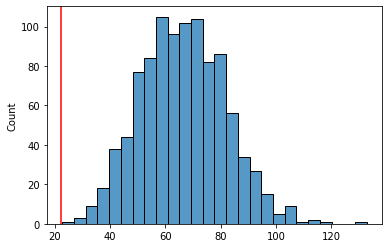

noise: 0.35 stat: 8.33360831690217  p = 0.0


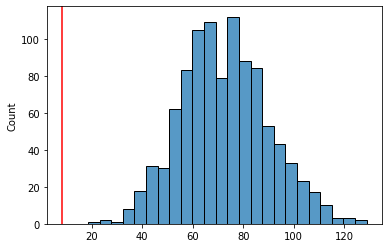

noise: 0.37 stat: 8.829897908638847  p = 0.0


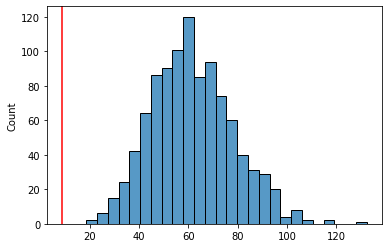

noise: 0.39 stat: 6.897702779460083  p = 0.0


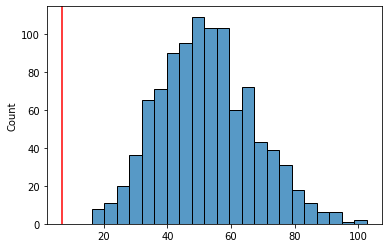

In [9]:
random = np.random.default_rng(42)

def phase_randomization(data):
    # Get the shape of the data
    num_samples, num_features = data.shape 
    # Create a copy of the data
    randomized_data = np.copy(data)
    # Iterate over each feature
    for i in range(num_features):
        data = randomized_data[:, i]
        fft_data = np.fft.fft(data)
        phase = random.permutation(np.angle(fft_data)) # same perm for all region
        randomized_data[:, i] = np.real(np.fft.ifft(np.abs(fft_data) * np.exp(1j * phase)))
    
    return randomized_data


from scipy.stats import chisquare

n_perm =1000
attractor_order  = [2, 0, 1, 3]

for noise in [0.33, 0.35, 0.37, 0.39]:
   
    # simulated
    sim_attractor_states = hopfield_embeddings_all[noise].attractor_sample
    label_sim, counts_sim = np.unique(sim_attractor_states, return_counts=True)
   
    # empirical
    embedded = hopfield_embeddings_all[noise].embedding_model.transform(all_ts[:1000])[:, :2]
    attractor_labels = hopfield_embeddings_all[noise].attractor_model.predict(embedded)
    label_emp, counts_emp = np.unique(attractor_labels, return_counts=True)
    true_test_stat = chisquare(counts_emp, counts_sim).statistic
   
    # null distribution for empirical
    test_stat_null = []
    for i in range(n_perm):
        
        # phase randomise all_ts[:1000, :] across axis = 1
        all_ts_phaserand = phase_randomization(all_ts[:1000, :])
        
        embedded = hopfield_embeddings_all[noise].embedding_model.transform(all_ts_phaserand)[:, :2]
        attractor_labels = hopfield_embeddings_all[noise].attractor_model.predict(embedded)
        label_emp_shuffled, counts_emp_shuffled = np.unique(attractor_labels, return_counts=True)
        #print(counts_emp / np.sum(counts_emp) * 100)
        #print(counts / np.sum(counts) * 100)
        test_stat_null.append(chisquare(counts_emp_shuffled, counts_sim).statistic) # does this differ from empirical data?
    sns.histplot(test_stat_null)
    plt.axvline(true_test_stat, color='red')
    print('noise:', noise, 'stat:', true_test_stat, ' p =', np.sum(np.array(test_stat_null) < true_test_stat) / n_perm)
    plt.show()

### Fractional occupancy is predicted for real data significantly better then for null data
#### regardless of the noise parameter!

### Null model 2: multivariate normal distribution

In [27]:
connfile = '../data_in/ex_connectome_partial_correlation.csv'
mtx = pd.read_csv(connfile).iloc[:, 1:]

random = np.random.default_rng(42)
sample = random.multivariate_normal(mean=np.repeat(0, mtx.shape[0]), cov=mtx, size=100)
sample.shape

(100, 122)

In [30]:
multivar_morm_attractor_states = {}
for noise in [0.33, 0.35, 0.37, 0.39]:
    tmp = []
    for s in tqdm(range(sample.shape[0])):
        tmp.append(hopfield_embeddings_all[noise].hopnet.update(sample[s, :])[0])
    multivar_morm_attractor_states[noise] = np.array(tmp)

100%|██████████| 100/100 [00:04<00:00, 20.78it/s]


In [31]:
from scipy.stats import chisquare

attractor_order  = [2, 0, 1, 3]

for noise in [0.33, 0.35, 0.37, 0.39]:
    print(noise)
    
    attractors = { tuple(v): k for k, v in hopfield_embeddings_all[noise].attractors.items() }
    attractor_labels = []
    
    for a in emp_attractor_states[noise]: 
        attractor_labels.append(attractors[tuple(np.round(a, 6))])
    
    label_emp, counts_emp = np.unique(attractor_labels[:1000], return_counts=True) # sample empirical data
    
    sim_attractor_states = hopfield_embeddings_all[noise].attractor_sample
    label, counts = np.unique(sim_attractor_states, return_counts=True)
    
    #plt.pie(counts[attractor_order], labels = label[attractor_order])
    # add a white circle at the center
    #my_circle=plt.Circle( (0,0), 0.7, color='white')
    #p=plt.gcf()
    #p.gca().add_artist(my_circle)
    #plt.show()
    print(counts_emp / np.sum(counts_emp) * 100)
    print(counts / np.sum(counts) * 100)
    print(chisquare(counts, counts_emp)) # does this differ from empirical data?

0.33
[38.8 36.4 12.9 11.9]
[45.3 35.4  9.6  9.7]
Power_divergenceResult(statistic=23.672987888329814, pvalue=2.9231147362649053e-05)
0.35
[12.9 38.8 36.4 11.9]
[10.4 42.5 36.2 10.9]
Power_divergenceResult(statistic=9.224636901216787, pvalue=0.026448610775167667)
0.37
[12.9 38.8 36.4 11.9]
[10.5 41.9 37.1 10.5]
Power_divergenceResult(statistic=8.723594610925904, pvalue=0.03320078808454163)
0.39
[12.9 38.8 11.9 36.4]
[10.5 40.7 10.7 38.1]
Power_divergenceResult(statistic=7.399568727773278, pvalue=0.060195896402164)


In [ ]:
from scipy.stats import chisquare

attractor_order  = [2, 0, 1, 3]

for noise in [0.33, 0.35, 0.37, 0.39]:
    print(noise)
    
    attractors = { tuple(v): k for k, v in hopfield_embeddings_all[noise].attractors.items() }
    attractor_labels = []
    
    for a in emp_attractor_states[noise]: 
        attractor_labels.append(attractors[tuple(np.round(a, 6))])
    
    label_emp, counts_emp = np.unique(attractor_labels[:1000], return_counts=True) # sample empirical data
    
    sim_attractor_states = hopfield_embeddings_all[noise].attractor_sample
    label, counts = np.unique(sim_attractor_states, return_counts=True)
    
    #plt.pie(counts[attractor_order], labels = label[attractor_order])
    # add a white circle at the center
    #my_circle=plt.Circle( (0,0), 0.7, color='white')
    #p=plt.gcf()
    #p.gca().add_artist(my_circle)
    #plt.show()
    print(counts_emp / np.sum(counts_emp) * 100)
    print(counts / np.sum(counts) * 100)
    print(chisquare(counts, counts_emp)) # does this differ from empirical data?